# Pix2Pix

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)
from torchsummary import summary


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### U-Net Code

The U-Net code will be much like the code you wrote for the last assignment, but with optional dropout and batchnorm. The structure is changed slightly for Pix2Pix, so that the final image is closer in size to the input image. Feel free to investigate the code if you're interested!

In [5]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return xn

In [ ]:
#My UNET Implementation
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_block,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            # nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            # nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.model(x)
class conv_transpose_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_transpose_block, self).__init__()
        
        self.model = nn.Sequential( 
                         nn.ConvTranspose2d(in_channels, out_channels, 2, 2, bias=False),
                         nn.InstanceNorm2d(out_channels),
                         nn.ReLU(inplace=True),
                    )

    def forward(self, x, skip_input,i):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):
        super(UNET,self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.c1 = conv_block(in_channels,64)
        self.c2 = conv_block(64,128)
        self.c3 = conv_block(128,256)
        self.c4 = conv_block(256,512)
        self.c5 = conv_block(512,1024)
        self.ct1 = conv_transpose_block(1024,512)
        self.c6 = conv_block(1024,512)
        self.ct2 = conv_transpose_block(512,256)
        self.c7 = conv_block(512,256)
        self.ct3 = conv_transpose_block(256,128)
        self.c8 = conv_block(256,128)
        self.ct4 = conv_transpose_block(128,64)
        self.c9 = conv_block(128,64)
        self.final = nn.Conv2d(64,out_channels,1)
            
    def forward(self,x):
        l1 = self.c1(x) # channels:64
        l2 = self.pool(l1)# size:256
        l3 = self.c2(l2)# channels:128
        l4 = self.pool(l3)# size:128 
        l5 = self.c3(l4)# channels:256
        l6 = self.pool(l5)# size:64
        l7 = self.c4(l6)# channels:512
        l8 = self.pool(l7)# size:32
        l9 = self.c5(l8)# channels:1024 
        l10 = self.ct1(l9,l7,1)# size:64 
        l11 = self.c6(l10)# channels:512
        l12 = self.ct2(l11,l5,2)# size:128
        l13 = self.c7(l12)# channels:256
        l14 = self.ct3(l13,l3,3)# size:256
        l15 = self.c8(l14)# channels:128
        l16 = self.ct4(l15,l1,4)# size:512
        l17 = self.c9(l16)# channels:64
        l18 = self.final(l17)# size:512 channels:3
        return l18

In [6]:
def print_images(image_tensor, num_images):
    print('reached')
    images = image_tensor
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


reached


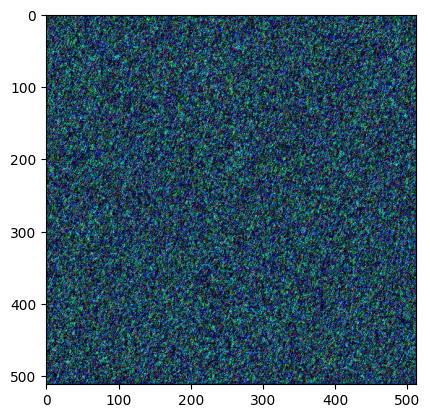

In [7]:
x = torch.randn((1,3,512,512))
model = UNet(3,3)
preds = model(x)
print_images(preds,1)

## PatchGAN Discriminator

Next, you will define a discriminator based on the contracting path of the U-Net to allow you to evaluate the realism of the generated images. Remember that the discriminator outputs a one-channel matrix of classifications instead of a single value. Your discriminator's final layer will simply map from the final number of hidden channels to a single prediction for every pixel of the layer before it.

In [8]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Structured like the contracting path of the U-Net, the discriminator will
    output a matrix of values classifying corresponding portions of the image as real or fake. 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        #### START CODE HERE ####
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)
        #### END CODE HERE ####

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [18]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 5
input_dim = 3
real_dim = 3
display_step = 200
batch_size = 1
lr = 0.0002
target_shape = 256
device = 'cuda'

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
DATADIR = r"D:\dataset\face2comics_v1.0.0_by_Sxela\face2comics_v1.0.0_by_Sxela\combined"
import torchvision
dataset = torchvision.datasets.ImageFolder(DATADIR, transform=transform)

In [12]:
gen = UNet(input_dim, real_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(input_dim + real_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = False
if pretrained:
    loaded_state = torch.load("D:\ganModels\pix2pix_3400.pth")
    gen.load_state_dict(loaded_state["gen"])
    gen_opt.load_state_dict(loaded_state["gen_opt"])
    disc.load_state_dict(loaded_state["disc"])
    disc_opt.load_state_dict(loaded_state["disc_opt"])
else:
    gen = gen.apply(weights_init)
    disc = disc.apply(weights_init)

In [13]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CLASS: get_gen_loss
def get_gen_loss(real,fake,target):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        disc: the discriminator; takes images and the condition and
          returns real/fake prediction matrices
        real: the real images (e.g. maps) to be used to evaluate the reconstruction
        condition: the source images (e.g. satellite imagery) which are used to produce the real images
        adv_criterion: the adversarial loss function; takes the discriminator 
                  predictions and the true labels and returns a adversarial 
                  loss (which you aim to minimize)
        recon_criterion: the reconstruction loss function; takes the generator 
                    outputs and the real images and returns a reconstructuion 
                    loss (which you aim to minimize)
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
    '''
    # Steps: 1) Generate the fake images, based on the conditions.
    #        2) Evaluate the fake images and the condition with the discriminator.
    #        3) Calculate the adversarial and reconstruction losses.
    #        4) Add the two losses, weighting the reconstruction loss appropriately.
    #### START CODE HERE ####
    # adv_criterion = nn.BCEWithLogitsLoss() 
    # recon_criterion = nn.L1Loss() 
    # with torch.no_grad():
    disc_output = disc(fake,real)
    gen_adv_loss = adv_criterion(disc_output, torch.ones_like(disc_output))
    gen_rec_loss = recon_criterion(fake,target)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss
    #### END CODE HERE ####
    return gen_loss

## Pix2Pix Training

Finally, you can train the model and see some of your maps!

In [14]:
def save_predictions_as_imgs(
    loader, model, folder="saved_image", device="cuda"
):
    # model.eval()
    print("Saving Images =>")
    idx = 0
    for image,_ in tqdm(loader):
        image_width = image.shape[3]
        target = image[:, :, :, :image_width // 2].to(device)
        real = image[:, :, :, image_width // 2:].to(device)
    
        with torch.no_grad():
            preds = model(real)
            # preds = DeNormalize(preds)
            # preds = (preds > 0.5).float()
        if idx%100 == 0:
            torchvision.utils.save_image(
                preds, f"{folder}/pred_{idx}.png"
            )
            torchvision.utils.save_image(target.squeeze(), f"{folder}/target_{idx}.png")
        idx += 1
        break

    model.train()

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
save_predictions_as_imgs(dataloader,gen)

Saving Images =>


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
from skimage import color
import numpy as np

def train(save_model=True):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for image, _ in tqdm(dataloader):
            image_width = image.shape[3]
            target = image[:, :, :, :image_width // 2]
            target = nn.functional.interpolate(target, size=target_shape)
            real = image[:, :, :, image_width // 2:]
            real = nn.functional.interpolate(real, size=target_shape)
            cur_batch_size = len(target)
            target = target.to(device)
            real = real.to(device)
            
            ### Update discriminator ###
            disc_opt.zero_grad() # Zero out the gradient before backpropagation
            # with torch.no_grad():
            fake = gen(real)
            # adv_criterion = nn.BCEWithLogitsLoss() 
            # recon_criterion = nn.L1Loss() 
            disc_real_hat = disc(real,target)
            disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
            
            disc_fake_hat = disc(real,fake.detach()) # Detach generator
            disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
            
            disc_loss = (disc_fake_loss + disc_real_loss) / 2
            disc_loss.backward(retain_graph=True) # Update gradients
            disc_opt.step() # Update optimizer

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(real,fake,target)
            gen_loss.backward() # Update gradients
            gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step

            ### Visualization code ###
            if cur_step % display_step == 0:
                if cur_step > 0:
                    print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
                else:
                    print("Pretrained initial state")
                show_tensor_images(target, size=(input_dim, target_shape, target_shape))
                show_tensor_images(real, size=(real_dim, target_shape, target_shape))
                show_tensor_images(fake, size=(real_dim, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                save_predictions_as_imgs(dataloader,gen)
                # You can change save_model to True if you'd like to save the model
                # if save_model:
                #     torch.save({'gen': gen.state_dict(),
                #         'gen_opt': gen_opt.state_dict(),
                #         'disc': disc.state_dict(),
                #         'disc_opt': disc_opt.state_dict()
                #     }, f"pix2pix_{cur_step}.pth")
            cur_step += 1


In [1]:
# train()

In [2]:
# FILE = "generator.pth"
# generator = UNet(3,3)
# dict = torch.load(FILE)
# generator.load_state_dict(dict)
# dir(dict)
# generator.eval()

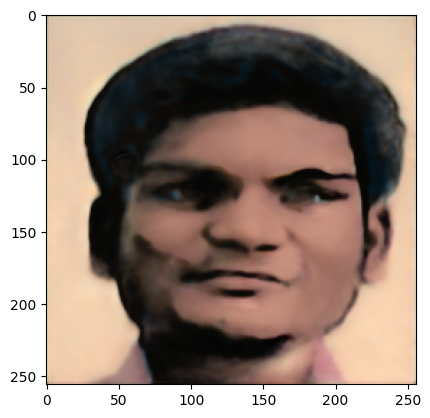

In [27]:
from PIL import Image 
img = Image.open(r"C:\Users\Aman Sheikh\Pictures\Aman_3.jpg")
print(img)
from torchvision import models, transforms, datasets
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop((256, 512)),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
generator = gen.to('cuda')
img = data_transform(img).to('cuda')
img = torch.unsqueeze(img,0)
output = generator(img)
# output = output.to('cuda')
show_tensor_images(output,size=(3, 256, 256))

In [1]:
FILE = "comic_generator.pt"
torch.save(gen.state_dict(),FILE)
FILE = "comic_discriminator.pt"
torch.save(disc.state_dict(),FILE)

NameError: name 'torch' is not defined